###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth, I. Hawke. Partly based on [HyperPython](http://nbviewer.ipython.org/github/ketch/HyperPython/tree/master/) by D.I. Ketcheson, also under CC-BY.

# Riding the wave

This is the fourth and final lesson of Module 3, _Riding the wave: convection problems_, of the course **"Practical Numerical Methods with Python"** (a.k.a., [#numericalmooc](https://twitter.com/hashtag/numericalmooc)). We learned about conservation laws and the traffic-flow model in the [first lesson](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_01_conservationLaw.ipynb), and then about better numerical schemes for convection in [lesson 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_02_convectionSchemes.ipynb). 

By then, you should have started to recognize that both mathematical models and numerical schemes work together to give us a good solution to a problem. To drive the point home, [lesson 3](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_03_aBetterModel.ipynb) deals only with an improved model—and showed you some impressive SymPy tricks!

In this lesson, we'll learn about a new class of discretization schemes, known as finite-volume methods. They are the _most widely used_ methods in computational fluid dynamics, and for good reasons! Let's get started ...

## Finite-volume method

Are you curious to find out why the finite-volume method (FVM) is the _most popular method_ in computational fluid dynamics? In fact, almost all of the commercial CFD software packages are based on the finite-volume discretization. Here are some reasons:

* FVM discretizations are very general and have no requirement that the grid be structured, like in the finite-difference method. This makes FVM very _flexible_.

* FVM gives a _conservative discretization_ automatically by using directly the conservation laws in integral form.

### Conservative discretization

Let's go right back to the start of this module, where we explained conservation laws looking at a tiny control volume. To simplify the discussion, we just looked at flow in one dimension, with velocity $u$. Imagining a tiny cylindrical volume, like the one shown in Figure 1, there is flux on the left face and right face and we easily explained conservation of mass in that case.

![1Dcontrolvolume](./figures/1Dcontrolvolume.png)
#### Figure 1. Tiny control volume in the shape of a cylinder.

The law of conservation of mass says that the rate of change of mass in the control volume, plus the net rate of flow of mass across the control surfaces must be zero. The same idea works for other conserved quantities.

Conservation means that any change in the quantity within a volume is due to the amount of that quantity that crosses the boundary. Sounds simple enough. (Remember that we are ignoring possible internal sources of the quantity.) The amount crossing the boundary is the flux. A general conservation law for a quantity $e$ is thus:

\begin{equation}
\frac{\partial}{\partial t}\int_{\text{cv}}e \, dV + \oint_{\text{cs}}\vec{F}\cdot d\vec{A} =0
\end{equation}

where $\vec{F}$ is the flux, and $\text{cv}$ denotes the control volume with control surface $\text{cs}$.

**Why not make the control volume itself our computational cell?**

Imagine that the one-dimensional domain of interest is divided using grid points $x_i$. But instead of trying to compute local values at the grid points, like we did before, we now want to follow the time evolution of _average_ values within each one-dimensional cell of width $\Delta x$ with center at $x_i$ (the idea is that as long as the cells are small enough, the average values will be a good representation of the quantities we are interested in). 

Define $e_i$ as the integral average across the little control volume on the cell with center at $x_i$ (see Figure 2).

$$
\begin{equation}
  e_i = \frac{1}{\Delta x} \int_{x_i - \Delta x / 2}^{x_i + \Delta x / 2} e(x, t) \, dx.
\end{equation}
$$

If we know the flux terms at the boundaries of the control volume, which are at $x_{i-1/2}$ and $x_{i+1/2}$, the general conservation law for this small control volume gives:

$$
\begin{equation}
  \frac{\partial}{\partial t} e_i + \frac{1}{\Delta x} \left[ F \left( x_{i+1/2}, t \right) - F \left( x_{i - 1 / 2}, t \right) \right] = 0.
\end{equation}
$$ 

This now just requires a time-stepping scheme, and is easy to solve *if* we can find $F$ on the control surfaces.

![finite volume](./figures/finite_volume.png)

#### Figure 2. Discretizing a 1D domain into finite volumes.

We've seen with the traffic model that the flux can depend on the conserved quantity (in that case, the traffic density). That is generally the case, so we write that $F = F(e)$. We will need to compute, or approximate, the flux terms at the cell edges (control surfaces) from the integral averages, $e_i$.

If we had a simple convection equation with $c>0$, then the flux going into the cell centered at $x_i$ from the left would be $F(e_{i-1})$ and the flux going out the cell on the right side would be $F(e_{i})$ (see Figure 2). Applying these fluxes in Equation (3) results in a scheme that is equivalent to our tried-and-tested backward-space (upwind) scheme! 

We know from previous lessons that the backward-space scheme is first order and the error introduces numerical diffusion. Also, remember what happened when we tried to use it with the non-linear [traffic model](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_01_conservationLaw.ipynb) in the green-light problem? *It blew up!* That was because the problem contains both right-moving and left-moving waves (if you don't remember that discussion, go back and review it; it's important!).

To skirt this difficulty in the green-light problem, we chose initial conditions that don't produce negative wave speeds. But that's cheating! A genuine solution would be to have a scheme that can deal with both positive and negative wave speeds. Here is where Godunov comes in.

### Godunov's method

Godunov proposed a first-order method in 1959 that uses the integral form of the conservation laws, Equation (1), and a piecewise constant representation of the solution, as shown in Figure (2). Notice that representing the solution in this way is like having a myriad of little shocks at the cell boundaries (control surfaces).

For each control surface, we have *two values* for the solution $e$ at a given time: the constant value to the left, $e_L$, and the constant value to the right, $e_R$. A situation where you have a conservation law with a constant initial condition, except for a single jump discontinuity is called a **Riemann problem**. 

The Riemann problem has an exact solution for the Euler equations (as well as for any scalar conservation law). The [shock-tube problem](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_05_Sods_Shock_Tube.ipynb), subject of your assignment for this course module, is a Riemann problem! And because it has an analytical solution, we can use it for testing the accuracy of numerical methods. 

But Godunov had a better idea. With the solution represented as piecewise constant (Figure 2), why not use the analytical solution of the Riemann problem at each cell boundary? Solving a Riemann problem gives all the information about the characteristic structure of the solution, including the sign of the wave speed. The full solution can then be reconstructed from the union of all the Riemann solutions at cell boundaries. *Neat idea, Godunov!*

Figure 3 illustrates a Riemann problem for the Euler equations, associated to the shock tube. The space-time plot shows the characteristic lines for the left-traveling expansion wave, and the right-traveling contact discontinuity and shock.

![Riemann-shocktube](./figures/Riemann-shocktube.png)

#### Figure 3. The shock tube: a Riemann problem for Euler's equations. Physical space (top) and $x, t$ space (bottom).

We need to solve many Riemann problems from $t$ to $\Delta t$, one on each cell boundary (illustrated in Figure 4). The numerical flux on $x_{i+1/2}$ is 

\begin{equation}
  F_{i+1/2}= \frac{1}{\Delta t} \int_{t^n}^{t^{n+1}} F\left(e(x_{i+1/2},t) \right)\,dt
\end{equation}

To be able to solve each Riemann problem independently, they should not interact, which imposes a limit on $\Delta t$. Looking at Figure 4, you might conclude that we must require a CFL number of 1/2 to avoid interactions between the Riemann solutions, but the numerical flux above only depends on the state at $x_{i+1/2}$, so we're fine as long as the solution there is not affected by that at $x_{i-1/2}$—i.e., the CFL limit is really 1.

![many_Rieman_problems](./figures/many_Rieman_problems.png)

#### Figure 4. Riemann problems on each cell boundary.

The Riemann solution, even though known analytically, can get quite hairy for non-linear systems of conservation laws (like the Euler equations). And we need as many Riemann solutions as there are finite-volume cell boundaries, and again at each time step! This gets really cumbersome. 

Godunov solved the Riemann problems exactly, but many after him proposed *approximate* Riemann solutions instead. We'll be calculating the full solution numerically, after all, so some controlled approximations can be made. You might imagine a simple approximation for the flux at a cell boundary that is just the average between the left and right values, for example: $\frac{1}{2}\left[F(e_L)+F(e_R)\right]$. But that leads to a central scheme and, on its own, is unstable. Adding a term proportional to the difference between left and right states, $e_R-e_L$, supplies artificial dissipation and gives stability (see van Leer et al., 1987).

One formula for the numerical flux at $x_{i+1/2}$ called the Rusanov flux, a.k.a. Lax-Friedrichs flux, is given by

\begin{equation}
  F_{i+1/2}= \frac{1}{2} \left[ F \left( e_L \right) + F \left( e_R \right)  \right] -  \frac{1}{2}  \max \left|F'(e)\right| \left( e_R - e_L \right)
\end{equation}

where $F'(e)$ is the Jacobian of the flux function and $\max\left|F'(e)\right|$ is the local propagation speed of the fastest traveling wave. The Riemann solutions at each cell boundary do not interact if $\max|F'(e)|\leq\frac{\Delta x}{\Delta t}$, which leads to a flux formula we can now use:

\begin{equation}
  F_{i+1/2}= \frac{1}{2} \left( F \left( e_{i} \right) + F \left( e_{i+1} \right) -  \frac{\Delta x}{\Delta t} \left( e_{i+1} - e_{i} \right) \right)
\end{equation}

### Let's try it!

Let's apply Godunov's method to the [LWR traffic model](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_01_conservationLaw.ipynb). In [lesson 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_02_convectionSchemes.ipynb) we already wrote functions to set the initial conditions for a red-light problem and to compute the fluxes.  To save us from  writing this out again, we saved those functions into a Python file named `traffic.py` (found in the same directory of the course repository).  Now, we can use those functions by importing them in the same way that we import NumPy or any other library. Like this:

In [1]:
from traffic import rho_red_light, computeF


You've probably noticed that we have the habit of writing detailed explanations of what a function does after defining it, in comments.  These comments are called *docstrings* and it is good practice to include them in all your functions.  It can be very useful when loading a function that you aren't familiar with (or don't remember!), because the `help` command will print them out for you.  Check it out:

In [2]:
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(nx, rho_max, rho_in)
    Computes "red light" initial condition with shock
    
    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars
    
    Returns
    -------
    rho: array of floats
        Array with initial values of density



Now, we can write some code to set up our notebook environment, and set the calculation parameters, with the functions imported above readily available.

In [3]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

In [4]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 101
nt = 30
dx = 4.0/(nx-2)

rho_in = 5.
rho_max = 10.

V_max = 1.

x = numpy.linspace(0,4,nx-1)


rho = rho_red_light(nx-1, rho_max, rho_in)

In [5]:
def animate(data):
    x = numpy.linspace(0,4,nx-1)
    y = data
    line.set_data(x,y)
    return line,

The cells above are code that you are already familiar with from lesson 2.  Below is a new function for applying Godunov's method with Lax-Friedrichs fluxes. Study it carefully.

In [6]:
def godunov(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the Godunov scheme using the Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
  
    for t in range(1,nt):
        
        rho_plus[:-1] = rho[1:] # Can't do i+1/2 indices, so cell boundary
        rho_minus = rho.copy() # arrays at index i are at location i+1/2
        flux = 0.5 * (computeF(V_max, rho_max, rho_minus) + 
                      computeF(V_max, rho_max, rho_plus) + 
                      dx / dt * (rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

We can run using a CFL of $1$, to start with, but you should experiment with different values.

In [7]:
sigma = 1.0
dt = sigma*dx/V_max

rho = rho_red_light(nx-1, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)

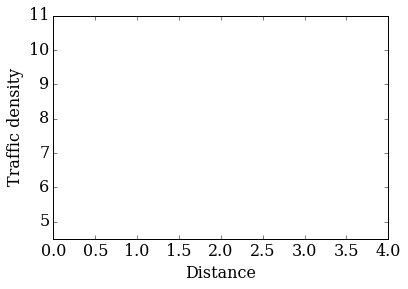

In [8]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

In [9]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

You'll see that the result is very similar to the original Lax-Friedrichs method, and with good reason: they're essentially the same! But this is only because we are using a uniform grid. In the finite-volume approach, using the integral form of the equations, we were free to use a spatially varying grid spacing, if we wanted to. 

The original Godunov method is first-order accurate, due to representing the conserved quantity by a piecewise-constant approximation. That is why you see considerable numerical diffusion in the solution. But Godunov's method laid the foundation for all finite-volume methods to follow and it was a milestone in numerical solutions of hyperbolic conservation laws. A whole industry developed inventing "high-resolution" methods that offer second-order accuracy and higher.

##### Dig deeper

* Godunov's method works in problems having waves moving with positive or negative wave speeds. Try it on the green-light problem introduced in [lesson 1](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_01_conservationLaw.ipynb) using the initial condition containing waves traveling in both directions.

* Investigate two or three different numerical flux schemes (you can start with van Leer et al., 1987, or Google for other references. Implement the different flux schemes and compare!

## MUSCL schemes

Godunov's method is first-order accurate, which we already know is not appropriate for hyperbolic conservation laws, due to the high numerical diffusion. This poses particular difficulty near sharp gradients in the solution.

To do better, we can replace the piecewise constant representation of the solution with a piecewise linear version (still discontinuous at the edges). This leads to the MUSCL scheme (for Monotonic Upstream-Centered Scheme for Conservation Laws), invented by van Leer (1979).

### Reconstruction in space

The piecewise linear reconstruction consists of representing the solution inside each cell with a *straight line* (see Figure 5). Define the cell representation as follows:

\begin{equation}
  e(x) = e_i + \sigma_i (x - x_i).
\end{equation}

where $\sigma_i$ is the *slope* of the approximation within the cell (to be defined), and $e_i$ is the Godunov cell average. The choice $\sigma_i=0$ gives Godunov's method.

Standard central differencing would give

\begin{equation}
  \sigma_i = \frac{e_{i+1} - e_{i-1}}{2 \Delta x}.
\end{equation}

<img src="./figures/cell_boundaries.svg">

#### Figure 5. Piecewise linear approximation of the solution.

But we saw with the results [in the second lesson](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_02_convectionSchemes.ipynb) that this can lead to oscillations near shocks. These [Gibbs oscillations](http://en.wikipedia.org/wiki/Gibbs_phenomenon) will always appear (according to [Godunov's theorem](http://en.wikipedia.org/wiki/Godunov's_theorem)) unless we use constant reconstruction. So we have to modify, or *limit* the slope, near shocks.

The easiest way to limit is to compute one-sided slopes

\begin{equation}
  \Delta e^- = \frac{e_i - e_{i-1}}{\Delta x}, \quad \Delta e^+ = \frac{e_{i+1} - e_{i}}{\Delta x}, 
\end{equation}

<img src="./figures/calc_sigma.svg">

#### Figure 6. One-sided slopes

Now build the *minmod* slope

\begin{align}
  \sigma_i & = \text{minmod}(\Delta e^-, \Delta e^+) \\
  & = \begin{cases} \min(\Delta e^-, \Delta e^+) & \text{ if } \Delta e^-, \Delta e^+ > 0 \\
  \max(\Delta e^-, \Delta e^+) & \text{ if } \Delta e^-, \Delta e^+ < 0 \\
0 & \text{ if } \Delta e^- \cdot \Delta e^+ \leq 0
  \end{cases}
\end{align}

That is, use the *smallest* one-sided slope in magnitude, unless the slopes have different sign, in which cases it uses the constant reconstruction (i.e., Godunov's method).

Once the *minmod* slope is calculated, we can use it to obtain the values at the interfaces between cells.

\begin{align}
e^{R}_{i-1/2} &= e_i - \sigma_i \frac{\Delta x}{2}\\
e^{L}_{i+1/2} &= e_i + \sigma_i \frac{\Delta x}{2}
\end{align}

where $e^R$ and $e^L$ are the local interpolated values of the conserved quantity immediately to the right and left of the cell boundary, respectively.  

##### Index headache

Notice that for the cell with index $i$, we calculate $e^R_{i-1/2}$ and $e^L_{i+1/2}$.  Look at Figure 5: those are the two local values of the solution are at opposite cell boundaries.

However, when we calculate the local flux at the cell boundaries, we use the local solution values on either side of that cell boundary. That is:

\begin{equation}
F_{i+1/2} = f(e^L_{i+1/2}, e^R_{i+1/2})
\end{equation}

You can calculate two flux vectors; one for the right-boundary values and one for the left-boundary values. Be careful that you know which boundary value a given index in these two vectors might refer to!

_____

Here is a Python function implementing minmod.

In [10]:
def minmod(e, dx):
    """
    Compute the minmod approximation to the slope
    
    Parameters
    ----------
    e : array of float 
        input data
    dx : float 
        spacestep
    
    Returns
    -------
    sigma : array of float 
            minmod slope
    """
    
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    # The following is inefficient but easy to read
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

### Evolution in time

Since we are aiming for second-order accuracy in space, we might as well try for second-order in time, as well. We need a method to evolve the *ordinary* differential equation forwards in time:

\begin{equation}
  \frac{\partial}{\partial t} e_i + \frac{1}{\Delta x} \left[ F \left( x_{i+1/2}, t \right) - F \left( x_{i - 1 / 2}, t \right) \right] = 0
\end{equation} 

A second-order Runge-Kutta method with special characteristics (due to Shu & Osher, 1988) gives the following scheme:

\begin{align}
e^*_i & = e^n_i + \frac{\Delta t}{\Delta x}\left( F^n_{i-1/2} - F^n_{i+1/2} \right) \\
e^{n+1}_i & = \frac{1}{2} e^n_i + \frac{1}{2}\left( e^*_i + \frac{\Delta t}{\Delta x}\left( F^*_{i-1/2} - F^*_{i+1/2} \right) \right)
\end{align}

Recall that the Rusanov flux is defined as
                          
$$
F_{i+1/2}= \frac{1}{2} \left[ F \left( e_L \right) + F \left( e_R \right)  \right] -  \frac{1}{2}  \max \left|F'(e)\right| \left( e_R - e_L \right)
$$

Armed with the interpolated values of $e$ at the cell boundaries we can generate a more accurate Rusanov flux. At cell boundary $i+1/2$, for example, this is:

\begin{equation}
F_{i+1/2} = \frac{1}{2} \left( F \left( e^L_{i+1/2} \right) + F \left( e^R_{i+1/2} \right)   -  \frac{\Delta x}{\Delta t} \left( e^R_{i+1/2} - e^L_{i+1/2} \right) \right)
\end{equation}

Now we are ready to try some MUSCL!

In [11]:
def muscl(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the MUSCL scheme using the Lax-Friedrichs flux,
    RK2 in time and minmod slope limiting.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star = numpy.zeros_like(rho)

    for t in range(1,nt):
               
        sigma = minmod(rho,dx) #calculate minmod slope

        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.     
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        #flux i = i + 1/2
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        #rk2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx * (flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        
        sigma = minmod(rho_star,dx) #calculate minmod slope
    
        #reconstruct values at cell boundaries
        rho_left = rho_star + sigma*dx/2.
        rho_right = rho_star - sigma*dx/2.
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        rho_n[t,1:-1] = .5 * (rho[1:-1] + rho_star[1:-1] + dt/dx * (flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [12]:
sigma = 1.
dt = sigma*dx/V_max
rho = rho_red_light(nx-1, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = muscl(rho, nt, dt, dx, rho_max, V_max)

In [13]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

This MUSCL scheme does not show any of the oscillations you might see with MacCormack or Lax-Wendroff, but the features are not as sharp. Using the _minmod_ slopes led to some smearing of the shock, which motivated many researchers to investigate other options. Bucketloads of so-called _shock-capturing_ schemes exist and whole books are written on this topic. Some people dedicate their lives to developing numerical methods for hyperbolic equations!

##### Challenge task

* Go back to Sod! Calculate the shock-tube problem using the MUSCL scheme and compare with your previous results. What do think?

## References

* Godunov, S.K. (1959), "A difference scheme for numerical computation of discontinuous solutions of equations of fluid dynamics," _Math. Sbornik_, Vol. 47, pp. 271–306.

* van Leer, Bram (1979), "Towards the ultimate conservative difference scheme, V. A second-order sequel to Godunov's method," _J. Comput. Phys._, Vol. 32, pp. 101–136

* van Leer, B., J.L. Thomas, P.L. Roe, R.W. Newsome (1987). "A comparison of numerical flux formulas for the Euler and Navier-Stokes equations," AIAA paper 87-1104 // [PDF from umich.edu](http://deepblue.lib.umich.edu/bitstream/handle/2027.42/76365/AIAA-1987-1104-891.pdf), checked 11/01/14.

* Shu, Chi-Wang and Osher, Stanley (1988). "Efficient implementation of essentially non-oscillatory shock-capturing schemes," _J. Comput. Phys._, Vol. 77, pp. 439–471 // [PDF from NASA Tech. Report server](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19870013797.pdf)

---

###### The cell below loads the style of the notebook.

In [14]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())